# E2a: Küchentischversuch zum Laval-Rotor

Name:  Paul Braun
Datum:  12.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Kann man mit dem Pi verlässlich Beschleunigungen messen? 

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/mixer.jpg" width="500">

- Beschreibung des Aufbaus: Der Beschleunigungssensor ist seitlich and einem Smoothiemixer der Marke WMF angeklebt.
- Vorgangsbeschreibung: Die Messung wird gestartet und zur selben Zeit wird der Mixer mit dem dauerhaften drücken auf den Knopf gestartet. 

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#setup_json_path = "/work/laval_rotor_experrment/datasheets/setup_compressor.json"
path_measurement_folder = "measurement_data/data_20240112_170446_PaulKonradBraun_mixer" # replace None by the relative path to the first object's folder
h5_file_name = "measurement_data/data_20240112_170446_PaulKonradBraun_mixer/data_20240112_170446_PaulKonradBraun_mixer.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240112_170446_PaulKonradBraun_mixer/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240112_170446_PaulKonradBraun_mixer/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240112_170446_PaulKonradBraun_mixer/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeae36b-bd44-6959-975f-e1df9689fd88": {
    "type": "probe",
    "name": "mixer",
    "comment": "",
    "path": "measurement_da

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
data = { "acceleration_x": [], "acceleration_y": [], "acceleration_z": [], "timestamp": []}

with h5py.File(h5_file_name, 'r') as f:
    for key in f["RawData"][sensor_settings_dict["ID"]].keys():
        data[key] = f["RawData"][sensor_settings_dict["ID"]][key][()]
a_x = data["acceleration_x"]
a_y = data["acceleration_y"]
a_z = data["acceleration_z"]
t_unix = data["timestamp"]
t = t_unix-t_unix[0]

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
a = get_vec_accel(a_x, a_y, a_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

In [6]:
plt.xlabel("time [s]")
plt.ylabel("acceleration [ms^-2]")
plt.plot(t, a, "r")

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


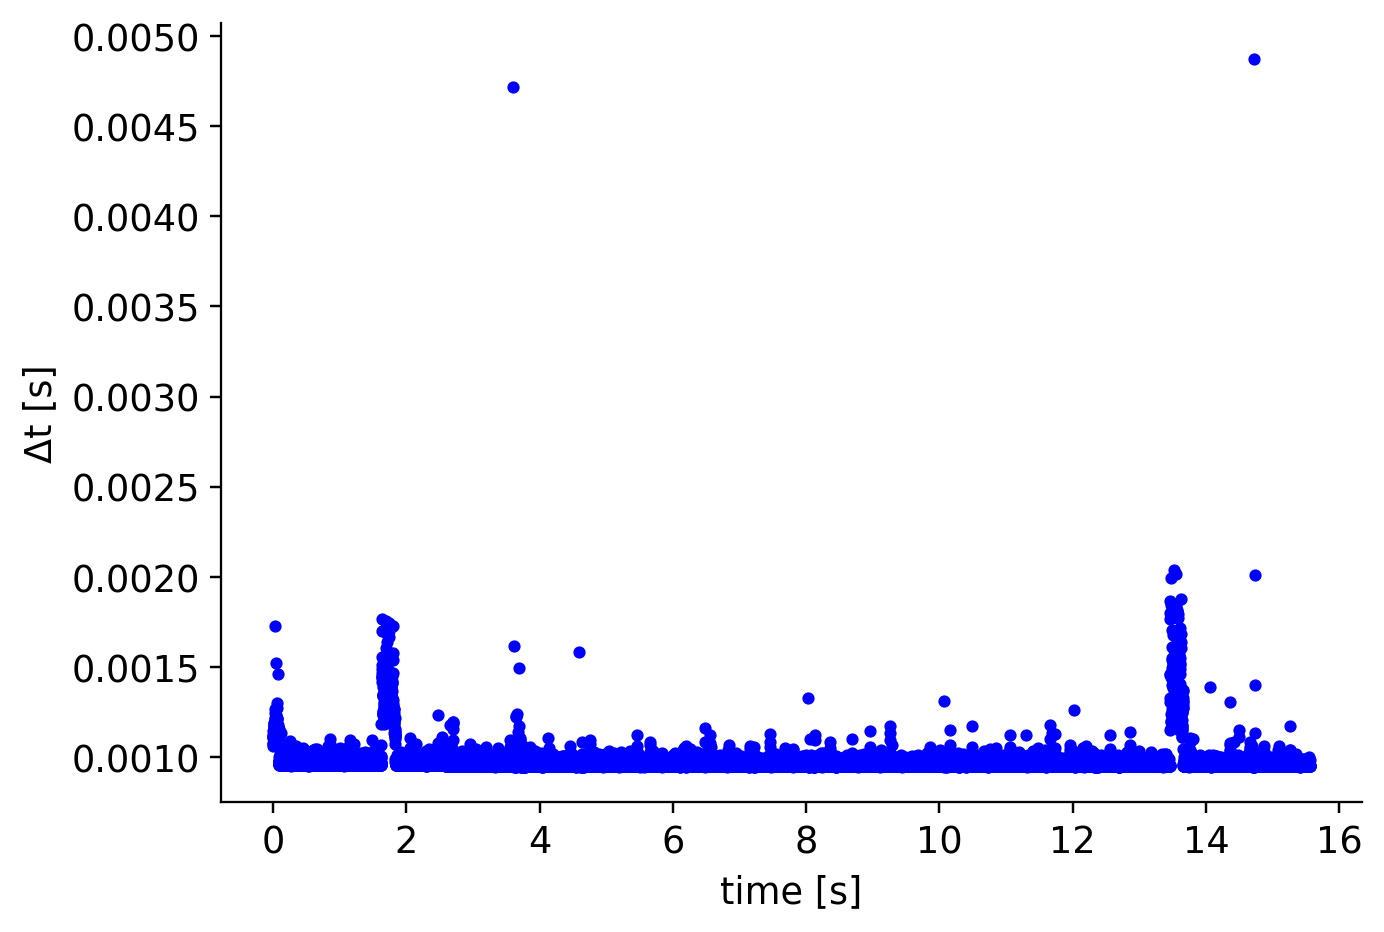

In [7]:
deltat = np.diff(t)
t_short = t[:-1] #+0.5 wegen zwischen den Zeitpunkten? 
plt.xlabel("time [s]")
plt.ylabel("Δt [s]")
plt.plot(t_short, deltat, ".""b")

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [8]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
newt, newa = interpolation(t, a)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

In [9]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
A, freq = my_fft(newa, newt)

plt.stem(freq, np.abs(A), "b", \
         markerfmt=" ", basefmt="-b")
plt.xlabel("frequency [Hz]")
plt.ylabel("Amplitude |A(freq)|")
plt.ylim(0,5000)
print("Nicht darstellbares Maximum von Amplitude |A(freq)|:")
print(max(np.abs(A)))    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Nicht darstellbares Maximum von Amplitude |A(freq)|:
194661.2120633799


# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/phone.jpg" width="500">

- Beschreibung des Aufbaus: Der Beschleunigungs ist an der Rückseite auf der Hülle des Handys mit Klebestreifen besfestigt. 
- Vorgangsbeschreibung: Es wird ein Wecker für eine Minute später gestellt. sobald der Wecker anfängt zu klingen wird die Messung gestartet. 

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = "measurement_data/data_20240112_171004_PaulKonradBraun_phone" # replace None by the relative path to the first object's folder
h5_file_name = "measurement_data/data_20240112_171004_PaulKonradBraun_phone/data_20240112_171004_PaulKonradBraun_phone.h5"

In [11]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240112_171004_PaulKonradBraun_phone/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240112_171004_PaulKonradBraun_phone/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240112_171004_PaulKonradBraun_phone/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeae371-583c-6d35-beba-0cdbdcbd2ca9": {
    "type": "probe",
    "name": "phone",
    "comment": "",
    "path": "measurement_da

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [12]:
data = { "acceleration_x": [], "acceleration_y": [], "acceleration_z": [], "timestamp": []}

with h5py.File(h5_file_name, 'r') as f:
    for key in f["RawData"][sensor_settings_dict["ID"]].keys():
        data[key] = f["RawData"][sensor_settings_dict["ID"]][key][()]
a_x = data["acceleration_x"]
a_y = data["acceleration_y"]
a_z = data["acceleration_z"]
t_unix = data["timestamp"]
t = t_unix-t_unix[0]

#### 2. Betrag der Beschleunigung berechnen


In [13]:
a = get_vec_accel(a_x, a_y, a_z)

#### 3. Darstellung der Messdaten

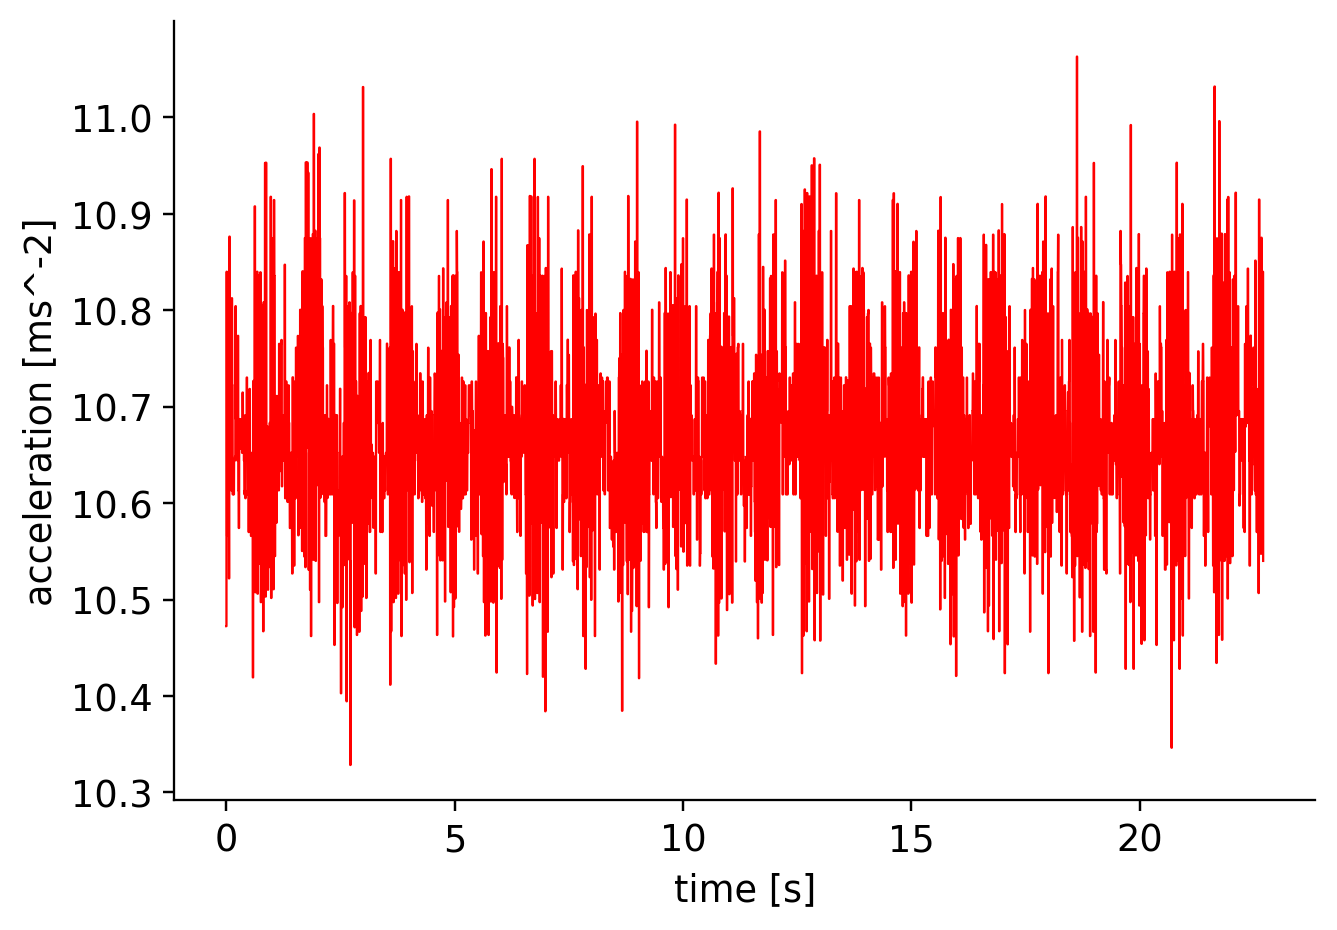

In [14]:
plt.xlabel("time [s]")
plt.ylabel("acceleration [ms^-2]")
plt.plot(t, a, "r")

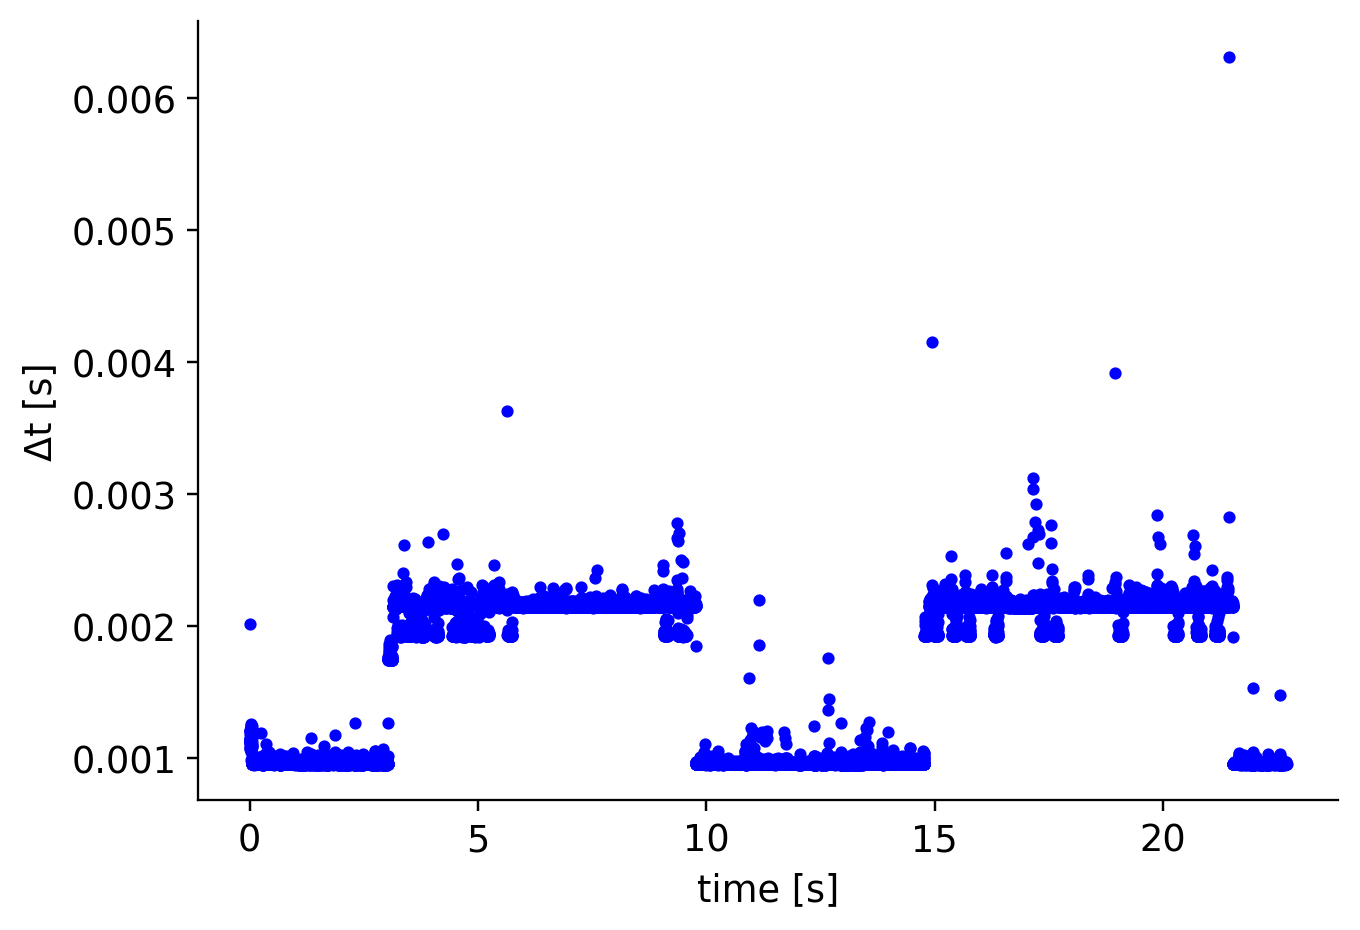

In [15]:
deltat = np.diff(t)
t_short = t[:-1] #+0.5 wegen zwischen den Zeitpunkten? 
plt.xlabel("time [s]")
plt.ylabel("Δt [s]")
plt.plot(t_short, deltat, ".""b")

#### 4. Interpolation der Messwerte



In [16]:
newt, newa = interpolation(t, a)

#### 5 & 6. FFT durchführen und graphisch darstellen


In [17]:
A, freq = my_fft(newa, newt)

plt.stem(freq, np.abs(A), "b", \
         markerfmt=" ", basefmt="-b")
plt.xlabel("frequency [Hz]")
plt.ylabel("Amplitude |A(freq)|")
plt.ylim(0,750)
print("Nicht darstellbares Maximum von Amplitude |A(freq)|:")
print(max(np.abs(A)))    

Nicht darstellbares Maximum von Amplitude |A(freq)|:
170759.68172653974


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Der Pi war keine merkliche Fehlerquelle, von der Zeitmessung abgesehen. Am schwierigsten war es beim Mixer konstant den Knopf zu drücken ohne die Messung zu beeinflussen. Daher hat es einige ANläufe gedauert ein gute Haltetechnik zu finden, bei der der Mixer noch frei schwingen kann. Bei der Darstellung der fft wird klar, dass es bei einer Frequenz von 0Hz eindeutig den höchsten Wert gibt. Das macht die Darstellung relativ schwierigyweshalb ich das Maximum nocheinmal explizit darüber geprintet habe. 

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Analyse der Daten hat Spaß gemacht, persönlich fand ich diese die bis jetzt beste Lerneinheit. Das Arbeiten an der Lerneinheit hat mein Verständnis für Dat